# Label Exploration

## Count the number of subjects with labels

In [1]:
import csv
from os import listdir
from os.path import exists

from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# label_file_path = r"/imaging3/owenlab/bpho/Biobank Labels/BehavData.csv"
label_file_path = r"/imaging3/owenlab/bpho/Biobank Labels/data-2020-07-21T15_31_07.904Z.csv"

In [4]:
label_subject_ids = set()  # Use set to grab unique subjects

with open(label_file_path) as csvfile:
    reader = csv.DictReader(csvfile)
    label_subject_ids = label_subject_ids.union(
        {row['assessment WISC,EID'] for row in reader})

print("Number of unique subjects:", len(label_subject_ids))

Number of unique subjects: 2279


In [5]:
data_subject_ids = set()

for age in range(5, 19):
    age_dir = f'/imaging3/owenlab/bpho/python_power_fc/Age{age}'
    
    if not exists(age_dir):
        continue
    
    data_subject_ids = data_subject_ids.union(
        {folder[4:] for folder in listdir(age_dir) if folder.startswith("sub-")})

    
print("Number of subjects with power FC:", len(data_subject_ids))

Number of subjects with power FC: 722


In [7]:
subjects_with_labels = label_subject_ids.intersection(data_subject_ids)
print("Number of subjects with labels and FC:", len(subjects_with_labels))

Number of subjects with labels and FC: 438


## Pandas Section (Write Labels to CSV)

In [8]:
subjects = pd.DataFrame(data_subject_ids, columns=['assessment WISC,EID'], dtype='str')
labels = pd.read_csv(label_file_path, dtype='str')
ages = labels["assessment Basic_Demos,Age"]
labels = labels.filter(like="WISC").join(ages)

# display(subjects)
# display(labels)

In [9]:
subjects_with_labels = labels.merge(subjects, on='assessment WISC,EID')
subjects_with_labels.set_index(keys='assessment WISC,EID', inplace=True)
# display(subjects_with_labels)
print(subjects_with_labels.columns)

Index(['assessment WISC,Administration', 'assessment WISC,Comment_ID',
       'assessment WISC,Data_entry', 'assessment WISC,Days_Baseline',
       'assessment WISC,PSCID', 'assessment WISC,START_DATE',
       'assessment WISC,Season', 'assessment WISC,Site',
       'assessment WISC,Study', 'assessment WISC,Visit_label',
       'assessment WISC,WISC_BD_Raw', 'assessment WISC,WISC_BD_Scaled',
       'assessment WISC,WISC_Coding_Raw', 'assessment WISC,WISC_Coding_Scaled',
       'assessment WISC,WISC_DS_Raw', 'assessment WISC,WISC_DS_Scaled',
       'assessment WISC,WISC_FRI', 'assessment WISC,WISC_FRI_Percentile',
       'assessment WISC,WISC_FRI_Sum', 'assessment WISC,WISC_FSIQ',
       'assessment WISC,WISC_FSIQ_Percentile', 'assessment WISC,WISC_FSIQ_Sum',
       'assessment WISC,WISC_FW_Raw', 'assessment WISC,WISC_FW_Scaled',
       'assessment WISC,WISC_MR_Raw', 'assessment WISC,WISC_MR_Scaled',
       'assessment WISC,WISC_PSI', 'assessment WISC,WISC_PSI_Percentile',
       'asses

In [10]:
subjects_with_labels = subjects_with_labels[
    subjects_with_labels['assessment WISC,WISC_complete'] == '1']
print("Number of subjects with WISC labels:", len(subjects_with_labels))

Number of subjects with WISC labels: 425


In [9]:
csv_output_path = "/imaging3/owenlab/bpho/Biobank Labels/Subjects with WISC.csv"
subjects_with_labels.to_csv(csv_output_path)

## Plot histograms

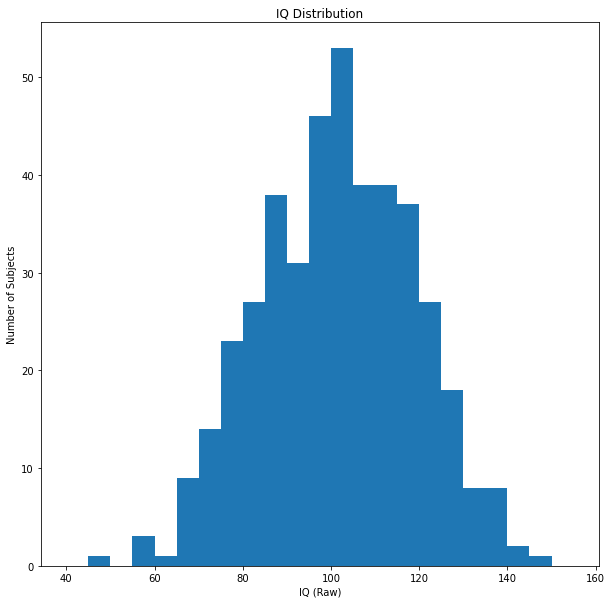

In [11]:
plt.figure(1, figsize=(10, 10))
plt.hist(x=subjects_with_labels['assessment WISC,WISC_FSIQ'].astype(float), bins=range(40, 160, 5))
plt.title("IQ Distribution")
plt.xlabel('IQ (Raw)')
plt.ylabel('Number of Subjects')
plt.show()

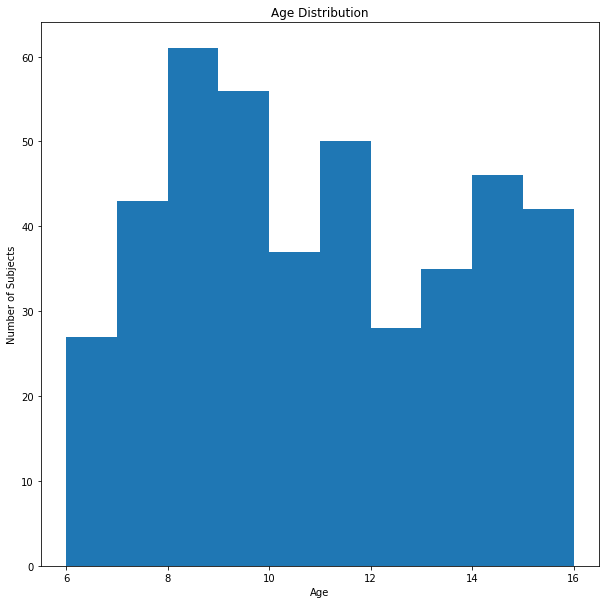

In [16]:
plt.figure(1, figsize=(10, 10))
plt.hist(x=subjects_with_labels['assessment Basic_Demos,Age'].astype(float), bins=range(6, 17, 1))
plt.title("Age Distribution")
plt.xlabel('Age')
plt.ylabel('Number of Subjects')
plt.show()

## Check relationship between Age and WISC

In [74]:
# Clean labels
clean_labels = labels[labels['assessment Basic_Demos,Age'] != "."]
clean_labels = clean_labels[clean_labels['assessment WISC,WISC_complete'] == '1']
clean_labels = clean_labels.dropna(axis='columns', how='all')

# Grab columns
wisc_col = 'assessment WISC'
wisc_raw_measures = [
    'WISC_BD_Raw', 
    'WISC_Similarities_Raw', 
    'WISC_MR_Raw',
    'WISC_DS_Raw',
    'WISC_Coding_Raw',
    'WISC_Vocab_Raw',
    'WISC_FW_Raw',
    'WISC_VP_Raw',
    'WISC_PS_Raw',
    'WISC_SS_Raw',
]
wisc_scaled_measure = [
    'WISC_BD_Scaled', 
    'WISC_Similarities_Scaled', 
    'WISC_MR_Scaled',
    'WISC_DS_Scaled',
    'WISC_Coding_Scaled',
    'WISC_Vocab_Scaled',
    'WISC_FW_Scaled',
    'WISC_VP_Scaled',
    'WISC_PS_Scaled',
    'WISC_SS_Scaled',
]
wisc_measures = np.array([wisc_raw_measures, wisc_scaled_measure]).flatten('F')

clean_labels = clean_labels.dropna(subset=[f'assessment WISC,{measure}' for measure in wisc_measures])
age = clean_labels['assessment Basic_Demos,Age'].astype(float)
wisc_measures_data = {measure: clean_labels[f'{wisc_col},{measure}'].astype(int).to_numpy() 
                      for measure in wisc_measures}
print("Num WISC measures:", len(wisc_measures_data))
print("Num subjects:", len(age))

Num WISC measures: 20
Num subjects: 2123


In [46]:
age = age.to_numpy().reshape(-1, 1)

print(age.shape)

(2123, 1)


In [75]:
for measure, data in wisc_measures_data.items():
    lin_reg = stats.linregress(age, data)
    print(f"{measure} r-squared:: {lin_reg.rvalue**2:.4f}")
    print(f"{measure} p-value: {lin_reg.pvalue}")
    print("--------------------------------------------")

WISC_BD_Raw r-squared:: 0.2691
WISC_BD_Raw p-value: 1.4900946607718205e-146
--------------------------------------------
WISC_BD_Scaled r-squared:: 0.0120
WISC_BD_Scaled p-value: 4.2243521348452356e-07
--------------------------------------------
WISC_Similarities_Raw r-squared:: 0.3725
WISC_Similarities_Raw p-value: 6.404144936738905e-217
--------------------------------------------
WISC_Similarities_Scaled r-squared:: 0.0165
WISC_Similarities_Scaled p-value: 2.7535534802113836e-09
--------------------------------------------
WISC_MR_Raw r-squared:: 0.3045
WISC_MR_Raw p-value: 1.6797971890973636e-169
--------------------------------------------
WISC_MR_Scaled r-squared:: 0.0000
WISC_MR_Scaled p-value: 0.7916949352578099
--------------------------------------------
WISC_DS_Raw r-squared:: 0.3018
WISC_DS_Raw p-value: 1.1245608051540533e-167
--------------------------------------------
WISC_DS_Scaled r-squared:: 0.0009
WISC_DS_Scaled p-value: 0.15848028697039498
-------------------------

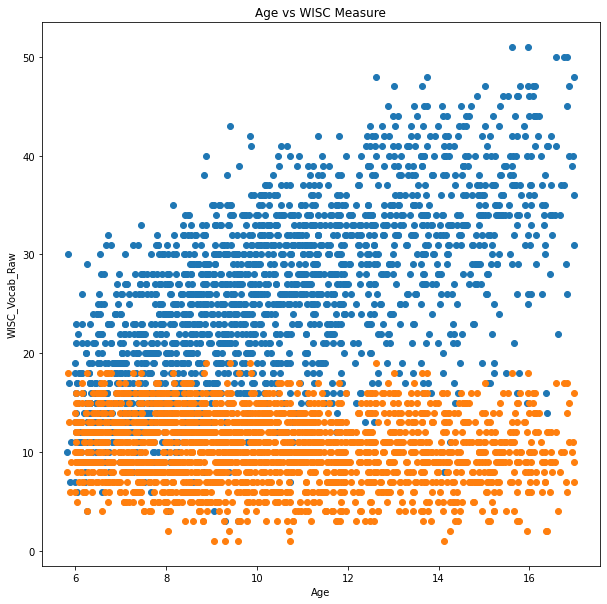

In [76]:
X = age
y = wisc_measures_data['WISC_Vocab_Raw']

plt.figure(1, figsize=(10, 10))
plt.scatter(X, y)
plt.scatter(X, wisc_measures_data['WISC_Vocab_Scaled'])
plt.title("Age vs WISC Measure")
plt.xlabel('Age')
plt.ylabel('WISC_Vocab_Raw')
plt.show()